In [13]:
%pip install qiskit[visualization]
%pip install qiskit-ibm-runtime
%pip install qiskit-aer


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 9.5/9.5 MB 3.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# config
token="USE_YOUR_API_KEY"
channel="local" # use "local" for simulator | "ibm_quantum" for real hardware

In [17]:
# obtain backend
backend = None

if channel == "local":
    from qiskit_aer import AerSimulator

    backend = AerSimulator()
else:
    from qiskit_ibm_runtime import QiskitRuntimeService

    service = QiskitRuntimeService(token=token, channel=channel)
    backend = service.least_busy(operational=True, simulator=False)

print("Using:", backend.name, f"({backend.backend_version}: {backend.description})")

Using: aer_simulator (0.15.1: A C++ Qasm simulator with noise)


In [18]:
from qiskit.circuit import QuantumCircuit

import numpy as np

In [19]:
def circuit_amod15(a: int, power: int):
    """Controlled multiplication by a^power mod 15"""

    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must not have common factors with 15")
    
    U = QuantumCircuit(4)

    for _ in range(power):
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    
    return U.control()

In [20]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [21]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(circuit_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_qc: QuantumCircuit = pass_manager.run(qc)

sampler = Sampler(backend)
job = sampler.run([isa_qc])

print(f"job id: {job.job_id()}")

result = job.result()

print(f"resulting PUBs: {len(result)}")
print(f"associated metadata: {result[0].metadata}")
print(f"associated DataBins: {result[0].data}")
print(f"DataBin has attributes: {result[0].data.keys()}")
print(f"Measurements: {result[0].data.c.get_counts()}")

counts = result[0].data.c.get_counts()

print(list(counts.values())[0])

job id: 79a90494-42a8-44d5-8f6a-e80bff6e8344
resulting PUBs: 1
associated metadata: {'shots': 1024, 'circuit_metadata': {}}
associated DataBins: DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=8>))
DataBin has attributes: dict_keys(['c'])
Measurements: {'00000000': 254, '01000000': 264, '11000000': 265, '10000000': 241}
254


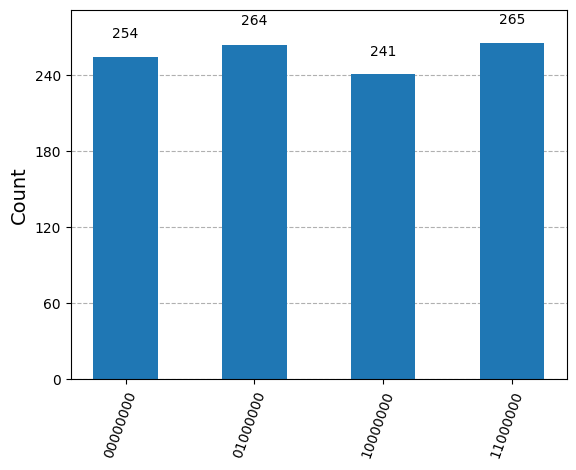

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

In [13]:
from fractions import Fraction
import pandas as pd

rows, measured_phases = [], []
for output in counts:
    print(output)

    decimal = int(output, 2)  # Convert (base 2) string to decimal

    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    frac = Fraction(phase).limit_denominator(15)
    
    # Add these values to the rows in our table:
    rows.append([
        f"{output}(bin) = {decimal:>3}(dec)",
        f"{decimal}/{2**N_COUNT} = {phase:.2f}",
        f"{frac.numerator}/{frac.denominator}",
        frac.denominator
    ])

# Print the rows in a table
headers=["Register Output", "Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


00000000
01000000
11000000
10000000
            Register Output           Phase Fraction  Guess for r
0  00000000(bin) =   0(dec)    0/256 = 0.00      0/1            1
1  01000000(bin) =  64(dec)   64/256 = 0.25      1/4            4
2  11000000(bin) = 192(dec)  192/256 = 0.75      3/4            4
3  10000000(bin) = 128(dec)  128/256 = 0.50      1/2            2


In [22]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    # Build Circuit
    N_COUNT = 8

    qc = QuantumCircuit(4+N_COUNT, N_COUNT)

    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    
    qc.x(N_COUNT) # And auxiliary register in state |1>

    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(circuit_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])
    
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))

    # Execute
    pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
    isa_qc: QuantumCircuit = pass_manager.run(qc)
    
    sampler = Sampler(backend)
    job = sampler.run([isa_qc])
    
    print(f"job id: {job.job_id()}")
    
    result = job.result()
    
    print(f"resulting PUBs: {len(result)}")
    print(f"associated metadata: {result[0].metadata}")
    print(f"associated DataBins: {result[0].data}")
    print(f"DataBin has attributes: {result[0].data.keys()}")
    print(f"Measurements: {result[0].data.c.get_counts()}")

    counts = result[0].data.c.get_counts()
    reading = list(counts.keys())[0]
    phase = int(reading, 2) / (2**N_COUNT)

    print(f"Register: reading = {reading} phase = {phase}")

    return phase
    

In [23]:
from math import gcd
from datetime import datetime as dt

import random

N = 15
TIMEOUT = 60
MAX_TRIVIAL_FACTORS_TO_FIND = 2

print(f"Choosing a value for `a` with N as: {N}")

a = random.choice([2, 4, 7, 8, 11, 13])

while a > N or gcd(a, N) != 1:
    a = random.choice([2, 4, 7, 8, 11, 13])

print(f"Using `a` as: {a}")

print(f"Starting Shor's Algo With: timeout = {TIMEOUT}s N = {N} a = {a} MAX_TRIVIAL_FACTORS_TO_FIND = {MAX_TRIVIAL_FACTORS_TO_FIND}")

attempt, found, start_time = 0, {}, dt.now()

while (len(found) < MAX_TRIVIAL_FACTORS_TO_FIND) and ((dt.now() - start_time).total_seconds() < TIMEOUT):
    attempt += 1
    
    print(f"\nATTEMPT {attempt}:")

    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator

    print(f"Result: r = {r}")

    if phase != 0:
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                print(f"*** Non-trivial factor found: {guess} ***")
                found[guess] = True

print(f"Non-Trivial Factors Found: {found.keys()}")

Choosing a value for `a` with N as: 15
Using `a` as: 11
Starting Shor's Algo With: timeout = 60s N = 15 a = 11 MAX_TRIVIAL_FACTORS_TO_FIND = 2

ATTEMPT 1:
job id: ef32305d-bb7a-4e71-a318-df6849335e1d
resulting PUBs: 1
associated metadata: {'shots': 1024, 'circuit_metadata': {}}
associated DataBins: DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=8>))
DataBin has attributes: dict_keys(['c'])
Measurements: {'10000000': 546, '00000000': 478}
Register: reading = 10000000 phase = 0.5
Result: r = 2
Guessed Factors: 5 and 3
*** Non-trivial factor found: 5 ***
*** Non-trivial factor found: 3 ***
Non-Trivial Factors Found: dict_keys([5, 3])


In [75]:
import math

t = 13
T = 2 ** 13
N = 77

print(f"N^2 = {N**2} < T = {T} < 2N^2 = {2 * (N**2)}")
print(f"n = log2 N = {math.log2(N)}")

N^2 = 5929 < T = 8192 < 2N^2 = 11858
n = log2 N = 6.266786540694901


In [78]:
n = len("{0:b}".format(77))
a = 2
N = 15

n

7

In [13]:
import numpy as np

def a2jmodN(a, j, N):
    """
    Compute a^{2^j} (mod N) by repeated squaring
    
    Parameters:
    -----------
    a: int
        Value for a
    j: int
        Value for j
    N: int
        Value for N
        
    Returns:
    --------
    a: int
        a^{2^j} (mod N)
    """
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [14]:
[print([a2jmodN(y, x, 77) for x in range(20)]) for y in range(77)]

[0, np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[1, np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[2, np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25)]
[3, np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.int64(4), np.int64(16), np.int64(25), np.int64(9), np.i

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
from math import gcd

gcd(11, 77)

11